# 分钟级策略

In [1]:
import pandas as pd
import numpy as np
import datetime
import talib
from wmpy.conf.settings import product_info_df, trade_days_list
from wmpy.trader.utility import get_previous_date, load_bar, load_bar_period
from wmpy.app.cta_backtester.backtesting_bar import cal_all_pnl, cal_daily_pnl # 注意这里是backtesting_bar

# 趋势性策略

In [60]:
#过滤掉非交易时间
def bar_filter(bar_df, contract=None):
    def is_trading_time(dt):
        condition = (
            (dt.time() >= datetime.time(9, 0) and dt.time() < datetime.time(11, 30))    # 上午
         or (dt.time() >= datetime.time(13, 0) and dt.time() < datetime.time(15, 0))  # 下午
         or (dt.time() >= datetime.time(21, 0) and dt.time() < datetime.time(23, 0)))   # 夜盘
        return condition
    bool_list = [is_trading_time(x) for x in bar_df.index]
    return bar_df.loc[bool_list].copy()

In [2]:
#查看期货品种
import qgrid
qgrid.show_grid(product_info_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [62]:
# MACD策略
def MACD_strategy(bar_df, date, contract, parameter_dict=None):
    # 参数
    FAST_PERIOD = parameter_dict['FAST_PERIOD']
    SLOW_PERIOD = parameter_dict['SLOW_PERIOD']
    SIGNAL_PERIOD = parameter_dict['SIGNAL_PERIOD']
    # 调取前1天数据预热
    start_date = get_previous_date(date, 1)
    end_date = date
    data_df = load_bar_period(contract, start_date, end_date)
    data_df = bar_filter(data_df)
    # 简单的MACD策略
    # DIF、MACD>0 ,开仓做多
    # DIF、MACD<0 ,开仓做空
    # DIF<0 平多，DIF>0 平空
    price = data_df['close_price']
    DIF = talib.EMA(price, timeperiod=FAST_PERIOD) - talib.EMA(price, timeperiod=SLOW_PERIOD)
    DEA = talib.EMA(DIF, timeperiod=SIGNAL_PERIOD)
    MACD = 2*(DIF - DEA)
    signal_ser = pd.Series(data = 0,index = bar_df.index) 
    
    for i in range(1,len(signal_ser)):
        last_signal = signal_ser[i-1]
        if last_signal == 0:
            if DIF[i]>0 and MACD[i]>0:
                signal_ser[i] = 1
            elif DIF[i]<0 and MACD[i]<0:
                signal_ser[i] = -1
            else:
                signal_ser[i] = 0
        elif last_signal == 1:
            if DIF[i] < 0:
                signal_ser[i] = 0
            else:
                signal_ser[i] = 1
        else:
            if DIF[i] > 0:
                signal_ser[i] = 0
            else:
                signal_ser[i] = -1
    
    # 过滤掉夜盘的信号，防止隔夜持仓，也防止加班盯盘
    if len(np.unique(bar_df.index.date)) > 1:
        current_date = bar_df.index[-1].date()
        # 以凌晨3点位分界，划分夜盘和日盘
        split_time = datetime.datetime.combine(current_date, datetime.time(3, 0))

        night_end_time = bar_df[:split_time].index[-1]
        day_start_time = bar_df[split_time:].index[0]
        signal_ser.loc[:night_end_time] = 0

    position_ser = signal_ser.shift(1)
    position_ser.iloc[0] = 0          # 头一分钟无仓位
    position_ser.iloc[-1] = 0         # 收盘时也清仓
    
    return position_ser

In [63]:
# 网格搜索调整参数
best_score = -10000
for slow_period in [15,30,60,120,270]:
    for fast_period in [10,20,30,60,90]:
        if slow_period<=fast_period:
            break  
        for signal_period in [5,10,20,40,50]:
        # 对于每种参数可能的组合，进行一次训练
            if fast_period<=signal_period:
                break  
            parameter_dict = dict(FAST_PERIOD = fast_period,SLOW_PERIOD = slow_period,SIGNAL_PERIOD = signal_period)
            df = cal_all_pnl(20190104, 20201231, MACD_strategy, parameter_dict, symbol='rb', contract=None, workers=None,mode='take', verbose=False, bar_filter=bar_filter)
            df.loc[datetime.date(2020, 2, 3)] = 0, 0, 0, 0, 0
            df.loc[datetime.date(2020, 12, 21)] = 0, 0, 0, 0, 0
            score = df['net_pnl'].sum()
            # 找到表现最好的参数
            if score > best_score:
                best_score = score
                best_parameters = dict(FAST_PERIOD = fast_period,SLOW_PERIOD = slow_period,SIGNAL_PERIOD = signal_period)

2020-02-03  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-12-21  reach price limit
2020-12-21

In [64]:
best_parameters

{'FAST_PERIOD': 90, 'SLOW_PERIOD': 270, 'SIGNAL_PERIOD': 50}

In [65]:
best_score

-470.0

In [66]:
df = cal_all_pnl(20190104, 20210301, MACD_strategy, best_parameters, symbol='rb', contract=None, workers=None,mode='take', verbose=False, bar_filter=bar_filter)

2020-12-21  reach price limit


In [67]:
# 碰到了涨跌停，把df处理一下
df.loc[datetime.date(2020, 12, 21)] = 0, 0, 0, 0, 0

In [68]:
df

,total_pnl,net_pnl,commission,num,holding_period
2019-01-04,9.0,9.0,0.0,1.0,26.0
2019-01-07,2.0,2.0,0.0,1.0,26.0
2019-01-08,-10.0,-10.0,0.0,1.0,22.0
2019-01-09,-1.0,-1.0,0.0,1.0,21.0
2019-01-10,-0.0,-0.0,0.0,0.0,0.0
...,...,...,...,...,...
2021-02-23,-0.0,-0.0,0.0,0.0,0.0
2021-02-24,-30.0,-30.0,0.0,1.0,26.0
2021-02-25,6.0,6.0,0.0,1.0,4.0
2021-02-26,-0.0,-0.0,0.0,0.0,0.0


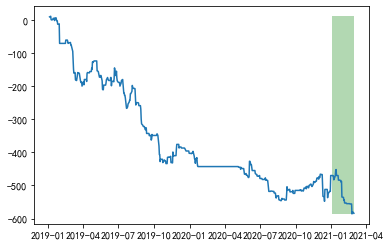

In [69]:
# 2021-1之后为样本外效果
import matplotlib.pyplot as plt
value_ser = df['net_pnl'].cumsum()
value_ser.plot()
plt.fill_between(value_ser[datetime.date(2021, 1, 1):].index,
                         value_ser.min(),
                         value_ser.max(),
                         facecolor='green',
                         alpha=0.3)

------------------------------
交易天数：	521
区间收益：	-584.00
日度胜率：	40.75%
日盈亏比：	0.88:1
------------------------------
最大回撤：	597.00
回撤起始：	2019-01-07
回撤结束：	2021-02-24
------------------------------
交易次数：	297.0
每日平均：	0.57
每笔收益：	-1.97
------------------------------
信息比率：	-0.12
------------------------------


(-584.0, 597.0, -1.9663299663299663, 297.0, 521, -0.12050695952578441)

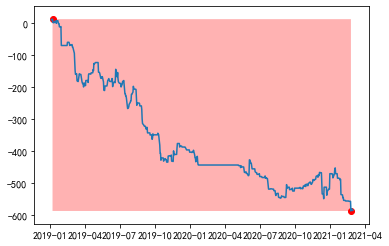

In [70]:
from wmpy.trader.utility import performance_summary
performance_summary(df, _plot=True, _print=True)

In [103]:
# 三均线策略
def tri_ma_strategy(bar_df, date, contract, parameter_dict=None):
    # 参数
    SHORT_PERIOD = parameter_dict['SHORT_PERIOD']
    MID_PERIOD = parameter_dict['MID_PERIOD']
    LONG_PERIOD = parameter_dict['LONG_PERIOD']
    # 调取前1天数据预热
    start_date = get_previous_date(date, 1)
    end_date = date
    data_df = load_bar_period(contract, start_date, end_date)
    data_df = bar_filter(data_df)
    # 简单的三均线策略
    # SHORT_MA,MID_MA>LONG_MA、SHORT_MA>MID_MA ,开仓做多
    # SHORT_MA,MID_MA<LONG_MA、SHORT_MA<MID_MA ,开仓做空
    # SHORT_MA<LONG_MA 平多，SHORT_MA>LONG_MA平空
    SHORT_MA = talib.SMA(data_df['close_price'],timeperiod = SHORT_PERIOD)
    MID_MA = talib.SMA(data_df['close_price'],timeperiod = MID_PERIOD)
    LONG_MA = talib.SMA(data_df['close_price'],timeperiod = LONG_PERIOD)

    signal_ser = pd.Series(data = 0,index = bar_df.index) 
    
    for i in range(1,len(signal_ser)):
        last_signal = signal_ser[i-1]
        if last_signal == 0:
            if SHORT_MA[i] > MID_MA[i] > LONG_MA[i]:
                signal_ser[i] = 1
            elif SHORT_MA[i] < MID_MA[i] < LONG_MA[i]:
                signal_ser[i] = -1
            else:
                signal_ser[i] = 0
        elif last_signal == 1:
            if SHORT_MA[i] < LONG_MA[i]:
                signal_ser[i] = 0
            else:
                signal_ser[i] = 1
        else:
            if SHORT_MA[i] > LONG_MA[i]:
                signal_ser[i] = 0
            else:
                signal_ser[i] = -1
    
    # 过滤掉夜盘的信号，防止隔夜持仓，也防止加班盯盘
    if len(np.unique(bar_df.index.date)) > 1:
        current_date = bar_df.index[-1].date()
        # 以凌晨3点位分界，划分夜盘和日盘
        split_time = datetime.datetime.combine(current_date, datetime.time(3, 0))

        night_end_time = bar_df[:split_time].index[-1]
        day_start_time = bar_df[split_time:].index[0]
        signal_ser.loc[:night_end_time] = 0

    position_ser = signal_ser.shift(1)
    position_ser.iloc[0] = 0          # 头一分钟无仓位
    position_ser.iloc[-1] = 0         # 收盘时也清仓
    
    return position_ser

In [104]:
# 网格搜索调整参数
best_score = -10000
for long_period in [15,30,60,120,270]:
    for mid_period in [10,20,30,60,120]:
        if long_period<=mid_period:
            break  
        for short_period in [5,10,20,40,60]:
        # 对于每种参数可能的组合，进行一次训练
            if mid_period<=short_period:
                break  
            parameter_dict = dict(SHORT_PERIOD = short_period, MID_PERIOD = mid_period, LONG_PERIOD =long_period)
            df = cal_all_pnl(20190104, 20201231, tri_ma_strategy, parameter_dict, symbol='m', contract=None, workers=None,mode='take', verbose=False, bar_filter=bar_filter)
            df.loc[datetime.date(2019, 5, 29)] = 0, 0, 0, 0, 0
            df.loc[datetime.date(2020, 3, 23)] = 0, 0, 0, 0, 0
            score = df['net_pnl'].sum()
            # 找到表现最好的参数
            if score > best_score:
                best_score = score
                best_parameters = dict(SHORT_PERIOD = short_period, MID_PERIOD = mid_period, LONG_PERIOD =long_period)

2019-05-29  reach price limit
2020-03-23  reach price limit
2019-05-29  reach price limit
2020-03-23  reach price limit
2019-05-29  reach price limit
2020-03-23  reach price limit
2019-05-29  reach price limit
2020-03-23  reach price limit
2019-05-29  reach price limit
2020-03-23  reach price limit
2019-05-29  reach price limit
2020-03-23  reach price limit
2019-05-29  reach price limit
2020-03-23  reach price limit
2019-05-29  reach price limit
2020-03-23  reach price limit
2019-05-29  reach price limit
2020-03-23  reach price limit
2019-05-29  reach price limit
2020-03-23  reach price limit
2019-05-29  reach price limit
2020-03-23  reach price limit
2019-05-29  reach price limit
2020-03-23  reach price limit
2019-05-29  reach price limit
2020-03-23  reach price limit
2019-05-29  reach price limit
2020-03-23  reach price limit
2019-05-29  reach price limit
2020-03-23  reach price limit
2019-05-29  reach price limit
2020-03-23  reach price limit
2019-05-29  reach price limit
2020-03-23

In [105]:
best_parameters

{'SHORT_PERIOD': 20, 'MID_PERIOD': 120, 'LONG_PERIOD': 270}

In [106]:
best_score

-451.0

In [107]:
df = cal_all_pnl(20190104, 20210301, tri_ma_strategy, best_parameters, symbol='m', contract=None, workers=None,mode='take', verbose=False, bar_filter=bar_filter)

2019-05-29  reach price limit


In [109]:
df.loc[datetime.date(2019,5 , 29)] = 0, 0, 0, 0, 0
df.loc[datetime.date(2020, 3, 23)] = 0, 0, 0, 0, 0

In [110]:
df

,total_pnl,net_pnl,commission,num,holding_period
2019-01-04,6.0,6.0,0.0,1.0,75.0
2019-01-07,7.0,7.0,0.0,1.0,75.0
2019-01-08,7.0,7.0,0.0,1.0,67.0
2019-01-09,4.0,4.0,0.0,1.0,71.0
2019-01-10,2.0,2.0,0.0,1.0,63.0
...,...,...,...,...,...
2021-02-23,7.0,7.0,0.0,1.0,5.0
2021-02-24,1.0,1.0,0.0,1.0,75.0
2021-02-25,-20.0,-20.0,0.0,2.0,60.0
2021-02-26,12.0,12.0,0.0,1.0,75.0


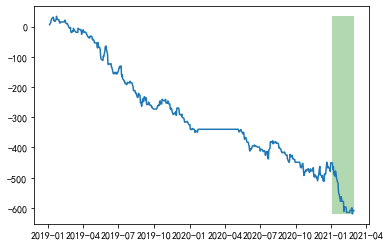

In [111]:
# 2021-1之后为样本外效果
import matplotlib.pyplot as plt
value_ser = df['net_pnl'].cumsum()
value_ser.plot()
plt.fill_between(value_ser[datetime.date(2021, 1, 1):].index,
                         value_ser.min(),
                         value_ser.max(),
                         facecolor='green',
                         alpha=0.3)

------------------------------
交易天数：	521
区间收益：	-609.00
日度胜率：	36.76%
日盈亏比：	1.05:1
------------------------------
最大回撤：	654.00
回撤起始：	2019-01-22
回撤结束：	2021-02-25
------------------------------
交易次数：	452.0
每日平均：	0.87
每笔收益：	-1.35
------------------------------
信息比率：	-0.15
------------------------------


(-609.0, 654.0, -1.3473451327433628, 452.0, 521, -0.1525141742212671)

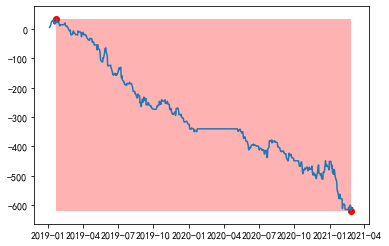

In [112]:
from wmpy.trader.utility import performance_summary
performance_summary(df, _plot=True, _print=True)

# 反转性策略

In [80]:
# RSI策略
def RSI_strategy(bar_df, date, contract, parameter_dict=None):
    # 参数
    RSI_WINDOW = parameter_dict['RSI_WINDOW']
    BUY_THRESHOLD = parameter_dict['OPEN_THRESHOLD']
    SELL_THRESHOLD = parameter_dict['CLOSE_THRESHOLD']
    # 调取前2天数据预热
    start_date = get_previous_date(date, 2)
    end_date = date
    data_df = load_bar_period(contract, start_date, end_date)
    data_df = bar_filter(data_df)
    # 简单的RSI策略
    RSI = talib.RSI(data_df['close_price'],RSI_WINDOW)
    
    score_ser = pd.Series(RSI, index=bar_df.index)
    
    BUY_OPEN_THRETHOD =  BUY_THRESHOLD
    SELL_OPEN_THRETHOD = SELL_THRESHOLD

    SELL_CLOSE_THRETHOD = SELL_THRESHOLD
    BUY_CLOSE_THRETHOD = BUY_THRESHOLD
    
    ## 根据信号确定仓位
    signal_ser = pd.Series(data=0, index=score_ser.index)

    ## 先确定开仓时点
    buy_open_bool = score_ser <= BUY_OPEN_THRETHOD
    signal_ser[buy_open_bool] = 1

    sell_open_bool = score_ser >= SELL_OPEN_THRETHOD
    signal_ser[sell_open_bool] = -1

    # 过滤掉夜盘的信号，防止隔夜持仓，也防止加班盯盘
    if len(np.unique(bar_df.index.date)) > 1:
        current_date = bar_df.index[-1].date()
        # 以凌晨3点位分界，划分夜盘和日盘
        split_time = datetime.datetime.combine(current_date, datetime.time(3, 0))

        night_end_time = bar_df[:split_time].index[-1]
        day_start_time = bar_df[split_time:].index[0]
        signal_ser.loc[:night_end_time] = 0


    ## 再确定平仓时点
    buy_close_bool = score_ser >= SELL_CLOSE_THRETHOD
    position_positive = pd.Series(data=np.nan, index=score_ser.index)
    position_positive.iloc[0] = 0
    position_positive[signal_ser == 1] = 1
    position_positive[buy_close_bool] = 0
    position_positive = position_positive.ffill()
    position_positive = position_positive.shift(1)

    sell_close_bool = score_ser <= BUY_CLOSE_THRETHOD
    position_negative = pd.Series(data=np.nan, index=score_ser.index)
    position_negative.iloc[0] = 0
    position_negative[signal_ser == -1] = -1
    position_negative[sell_close_bool] = 0
    position_negative = position_negative.ffill()
    position_negative = position_negative.shift(1)

    position_ser = position_positive + position_negative

    ## 返回这段时间的持仓序列
    position_ser = position_ser.fillna(0)
    position_ser = pd.Series(position_ser, index=bar_df.index)

    position_ser.iloc[0] = 0
    position_ser.iloc[-1] = 0
    position_ser.iloc[-2] = 0
    position_ser.iloc[-3] = 0
    
    return position_ser

In [81]:
# 网格搜索调整参数
best_score = -10000
for rsi_window in [5,10,30,60]:
    for open_treshold in [20,25,30,35,40]:
        for close_treshold in [80,75,70,65,60]:
        # 对于每种参数可能的组合，进行一次训练
            parameter_dict = dict(RSI_WINDOW=rsi_window, OPEN_THRESHOLD=open_treshold, CLOSE_THRESHOLD=close_treshold )
            df = cal_all_pnl(20190104, 20201231, RSI_strategy, parameter_dict, symbol='rb', contract=None, workers=None,mode='take', verbose=False, bar_filter=bar_filter)
            df.loc[datetime.date(2020, 2, 3)] = 0, 0, 0, 0, 0
            df.loc[datetime.date(2020, 12, 21)] = 0, 0, 0, 0, 0
            score = df['net_pnl'].sum()
            # 找到表现最好的参数
            if score > best_score:
                best_score = score
                best_parameters = dict(RSI_WINDOW=rsi_window, OPEN_THRESHOLD=open_treshold, CLOSE_THRESHOLD=close_treshold )

2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-02-03  reach price limit
2020-02-03  reach price limit
2020-02-03  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-02-03  reach price limit
2020-02-03  reach price limit
2020-02-03  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-02-03  reach price limit
2020-02-03  reach price limit
2020-02-03  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-02-03  reach price limit
2020-02-03  reach price limit
2020-02-03  reach price limit
2020-02-03  reach price limit
2020-12-21

In [83]:
best_parameters

{'RSI_WINDOW': 30, 'OPEN_THRESHOLD': 20, 'CLOSE_THRESHOLD': 75}

In [84]:

df = cal_all_pnl(20190104, 20210301, RSI_strategy, best_parameters, symbol='rb', contract=None, workers=None,mode='take', verbose=False, bar_filter=bar_filter)

2020-02-03  reach price limit
2020-12-21  reach price limit


In [85]:
df.loc[datetime.date(2020, 2, 3)] = 0, 0, 0, 0, 0
df.loc[datetime.date(2020, 12, 21)] = 0, 0, 0, 0, 0

In [86]:
df

,total_pnl,net_pnl,commission,num,holding_period
2019-01-04,-3.0,-3.0,0.0,1.0,84.0
2019-01-07,-0.0,-0.0,0.0,0.0,0.0
2019-01-08,-0.0,-0.0,0.0,0.0,0.0
2019-01-09,-0.0,-0.0,0.0,0.0,0.0
2019-01-10,-0.0,-0.0,0.0,0.0,0.0
...,...,...,...,...,...
2021-02-23,-0.0,-0.0,0.0,0.0,0.0
2021-02-24,-0.0,-0.0,0.0,0.0,0.0
2021-02-25,-0.0,-0.0,0.0,0.0,0.0
2021-02-26,-0.0,-0.0,0.0,0.0,0.0


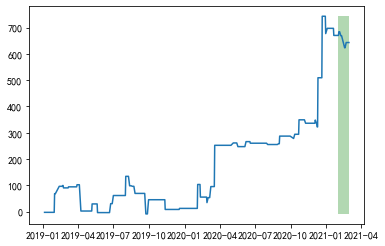

In [87]:
# 2021-2之后为样本外效果
import matplotlib.pyplot as plt
value_ser = df['net_pnl'].cumsum()
value_ser.plot()
plt.fill_between(value_ser[datetime.date(2021, 2, 1):].index,
                         value_ser.min(),
                         value_ser.max(),
                         facecolor='green',
                         alpha=0.3)

------------------------------
交易天数：	521
区间收益：	643.00
日度胜率：	55.10%
日盈亏比：	1.66:1
------------------------------
最大回撤：	143.00
回撤起始：	2019-08-02
回撤结束：	2019-09-23
------------------------------
交易次数：	49.0
每日平均：	0.09
每笔收益：	13.12
------------------------------
信息比率：	0.07
------------------------------


(643.0, 143.0, 13.122448979591837, 49.0, 521, 0.06663128486757997)

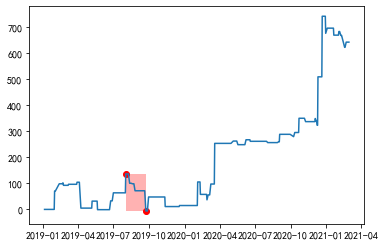

In [88]:
from wmpy.trader.utility import performance_summary
performance_summary(df, _plot=True, _print=True)

In [89]:
# 反转策略
def reverse_strategy(bar_df, date, contract, parameter_dict=None):
    # 参数
    N = parameter_dict['N']
    coefficient = parameter_dict['coefficient']
    
    # 调取前2天数据预热
    start_date = get_previous_date(date, 2)
    end_date = date
    data_df = load_bar_period(contract, start_date, end_date)
    data_df = bar_filter(data_df)
    # 反转策略
    # 若当前N分钟的最高价>观察卖出价，认为它已经到了当日阻力位，可能发生行情反转，在反转卖出价挂上卖出开仓的停止单
    # 若当前N分钟的最低价<观察买入价，认为它已经到了当日支撑位，可能发生行情反转，在反转买入价挂上买入开仓的停止单
    temp_df = data_df.copy()   # 防止改掉原数据，引起不必要的bug
    temp_df['cummax'] = temp_df['close_price'].rolling(N).max()
    temp_df['cummin'] = temp_df['close_price'].rolling(N).min()
    temp_df['Ssetup'] = temp_df['high_price']+coefficient*(temp_df['close_price']-temp_df['low_price'])
    temp_df['Bsetup'] = temp_df['low_price']-coefficient*(temp_df['high_price']-temp_df['close_price'])
    
    ## 根据信号确定仓位


    def _cal_signal(x):
        cummax = x['cummax']
        cummin = x['cummin']
        Ssetup = x['Ssetup']
        Bsetup = x['Bsetup']

        if pd.isna(cummax) or pd.isna(cummin) or pd.isna(Ssetup) or pd.isna(Bsetup):# 如果任意一个值为空
            signal = 0
        elif cummax > Ssetup:    
            signal = -1
        elif cummin < Bsetup:
            signal = 1
        else:
            signal = 0
        return signal

    temp_df['signal'] = temp_df.apply(_cal_signal, axis=1) # 对temp_df的每一行做判断
    temp_df['position'] = temp_df['signal'].shift(1) # 根据上一分钟的信号决定仓位
    temp_df = pd.DataFrame(temp_df, index=bar_df.index)
    signal_ser = temp_df['signal'].copy()
    position_ser = temp_df['position'].copy()
    
    # 过滤掉夜盘的信号，防止隔夜持仓，也防止加班盯盘
    if len(np.unique(bar_df.index.date)) > 1:
        current_date = bar_df.index[-1].date()
        # 以凌晨3点位分界，划分夜盘和日盘
        split_time = datetime.datetime.combine(current_date, datetime.time(3, 0))

        night_end_time = bar_df[:split_time].index[-1]
        day_start_time = bar_df[split_time:].index[0]
        signal_ser.loc[:night_end_time] = 0


    ## 返回这段时间的持仓序列
    position_ser.iloc[0] = 0
    position_ser.iloc[-1] = 0
    position_ser.iloc[-2] = 0
    position_ser.iloc[-3] = 0
    
    return position_ser

In [94]:
# 网格搜索调整参数
best_score = -20000
for n in [5,10,30,60]:
    for c in [0.1,0.15,0.2,0.25,0.3,0.35,0.4]:
        # 对于每种参数可能的组合，进行一次训练
            parameter_dict = dict(N = n, coefficient = c )
            df = cal_all_pnl(20190104, 20201231, reverse_strategy, parameter_dict, symbol='rb', contract=None, workers=None,mode='take', verbose=False, bar_filter=bar_filter)
            df.loc[datetime.date(2020, 2, 3)] = 0, 0, 0, 0, 0
            df.loc[datetime.date(2020, 12, 21)] = 0, 0, 0, 0, 0
            score = df['net_pnl'].sum()
            # 找到表现最好的参数
            if score > best_score:
                best_score = score
                best_parameters = dict(N = n, coefficient = c)

2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-12-21  reach price limit
2020-02-03  reach price limit
2020-12-21

In [95]:
best_parameters

{'N': 60, 'coefficient': 0.15}

In [96]:
df = cal_all_pnl(20190104, 20210301, reverse_strategy, best_parameters, symbol='rb', contract=None, workers=None,mode='take', verbose=False, bar_filter=bar_filter)

2020-02-03  reach price limit
2020-12-21  reach price limit


In [99]:
df.loc[datetime.date(2020, 2, 3)] = 0, 0, 0, 0, 0
df.loc[datetime.date(2020, 12, 21)] = 0, 0, 0, 0, 0

In [100]:
df

,total_pnl,net_pnl,commission,num,holding_period
2019-01-04,-19.0,-19.0,0.0,29.0,342.0
2019-01-07,-97.0,-97.0,0.0,34.0,342.0
2019-01-08,-1.0,-1.0,0.0,19.0,342.0
2019-01-09,-15.0,-15.0,0.0,29.0,342.0
2019-01-10,-60.0,-60.0,0.0,29.0,342.0
...,...,...,...,...,...
2021-02-23,20.0,20.0,0.0,13.0,342.0
2021-02-24,-57.0,-57.0,0.0,24.0,342.0
2021-02-25,-135.0,-135.0,0.0,30.0,342.0
2021-02-26,-33.0,-33.0,0.0,27.0,342.0


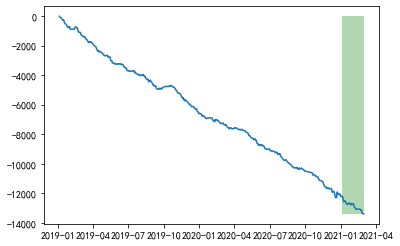

In [101]:
# 2021-1之后为样本外效果
import matplotlib.pyplot as plt
value_ser = df['net_pnl'].cumsum()
value_ser.plot()
plt.fill_between(value_ser[datetime.date(2021, 1, 1):].index,
                         value_ser.min(),
                         value_ser.max(),
                         facecolor='green',
                         alpha=0.3)

------------------------------
交易天数：	521
区间收益：	-13402.00
日度胜率：	29.15%
日盈亏比：	0.59:1
------------------------------
最大回撤：	13383.00
回撤起始：	2019-01-04
回撤结束：	2021-03-01
------------------------------
交易次数：	11500.0
每日平均：	22.07
每笔收益：	-1.17
------------------------------
信息比率：	-0.53
------------------------------


(-13402.0, 13383.0, -1.1653913043478261, 11500.0, 521, -0.5250363240941229)

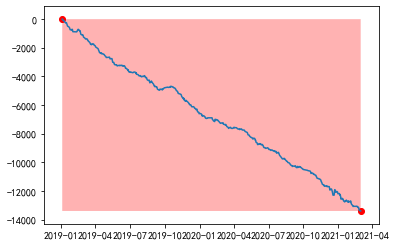

In [102]:
from wmpy.trader.utility import performance_summary
performance_summary(df, _plot=True, _print=True)